# Day_082

### 練習時間
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import itertools
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras import optimizers

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout
def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128], drp_ratio = 0.2):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units, 
                                   activation = "relu", 
                                   name = "hidden_layer" + str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = Dense(units=n_units, 
                                   activation = "relu", 
                                   name = "hidden_layer" + str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    output = Dense(units = output_units, activation = "softmax", name = "output")(x)
    
    model = Model(inputs = [input_layer], outputs = [output])
    return model

In [6]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.3, 0.5]

In [7]:
results = {}
for dropout_ratio in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout Ratio = %.6f" % (dropout_ratio))
    model = build_mlp(input_shape = x_train.shape[1:], drp_ratio = dropout_ratio)
    model.summary()
    optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-drp_rate-%s" % str(dropout_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Dropout Ratio = 0.300000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None,

Epoch 49/50
50000/50000 [==============================] - 33s 651us/step - loss: 1.3480 - acc: 0.5189 - val_loss: 1.3202 - val_acc: 0.5254
Epoch 50/50
50000/50000 [==============================] - 32s 648us/step - loss: 1.3470 - acc: 0.5210 - val_loss: 1.3237 - val_acc: 0.5251
Experiment with Dropout Ratio = 0.500000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)

50000/50000 [==============================] - 34s 676us/step - loss: 1.6115 - acc: 0.4217 - val_loss: 1.4958 - val_acc: 0.4674
Epoch 47/50
50000/50000 [==============================] - 33s 667us/step - loss: 1.6014 - acc: 0.4251 - val_loss: 1.4739 - val_acc: 0.4751
Epoch 48/50
50000/50000 [==============================] - 33s 664us/step - loss: 1.5998 - acc: 0.4244 - val_loss: 1.4854 - val_acc: 0.4663
Epoch 49/50
50000/50000 [==============================] - 34s 676us/step - loss: 1.6005 - acc: 0.4246 - val_loss: 1.4791 - val_acc: 0.4684
Epoch 50/50
50000/50000 [==============================] - 34s 673us/step - loss: 1.5934 - acc: 0.4296 - val_loss: 1.4693 - val_acc: 0.4717


In [8]:
def plt_model_result(result):
    color_bar = ["r", "g", "b", "y", "m", "k"]
    
    plt.figure(figsize=(16, 9))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16, 9))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

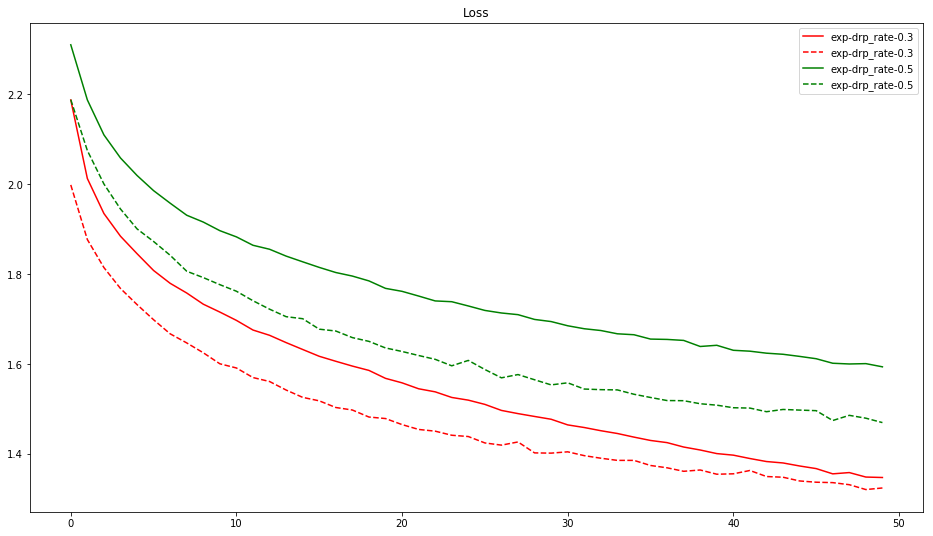

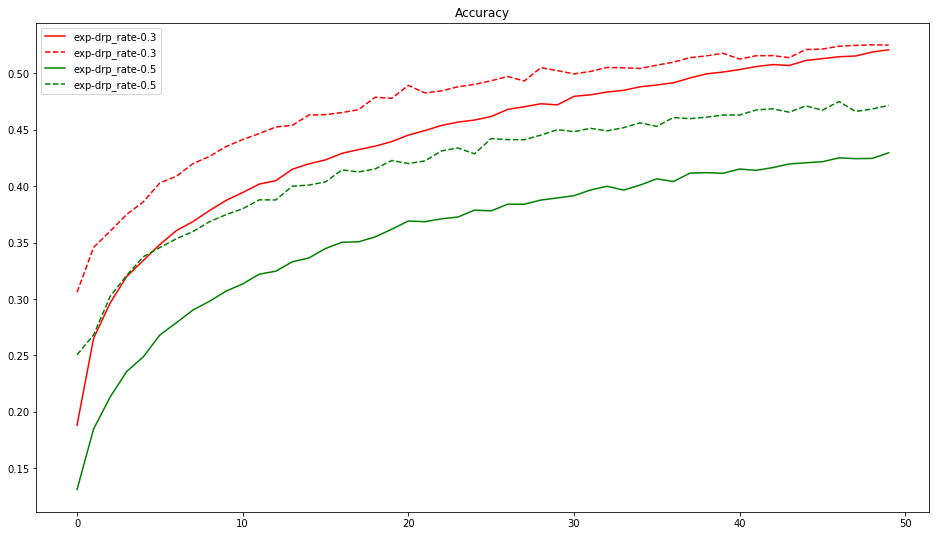

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt_model_result(results)

### 使用不同層數以及不同 Dropout rate

In [10]:
results = {}
for dropout_ratio in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout Ratio = %.6f" % (dropout_ratio))
    model = build_mlp(input_shape = x_train.shape[1:], num_neurons=[512, 256, 128, 64, 32], drp_ratio = dropout_ratio)
    model.summary()
    optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-drp_rate-%s" % str(dropout_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Dropout Ratio = 0.300000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None,

50000/50000 [==============================] - 34s 685us/step - loss: 1.6101 - acc: 0.4176 - val_loss: 1.5010 - val_acc: 0.4611
Epoch 46/50
50000/50000 [==============================] - 34s 681us/step - loss: 1.5993 - acc: 0.4214 - val_loss: 1.4998 - val_acc: 0.4659
Epoch 47/50
50000/50000 [==============================] - 34s 688us/step - loss: 1.6011 - acc: 0.4227 - val_loss: 1.4895 - val_acc: 0.4713
Epoch 48/50
50000/50000 [==============================] - 34s 677us/step - loss: 1.5925 - acc: 0.4254 - val_loss: 1.4844 - val_acc: 0.4687
Epoch 49/50
50000/50000 [==============================] - 34s 678us/step - loss: 1.5941 - acc: 0.4248 - val_loss: 1.4842 - val_acc: 0.4708
Epoch 50/50
50000/50000 [==============================] - 34s 685us/step - loss: 1.5824 - acc: 0.4301 - val_loss: 1.4799 - val_acc: 0.4716
Experiment with Dropout Ratio = 0.500000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

50000/50000 [==============================] - 33s 666us/step - loss: 2.0088 - acc: 0.1986 - val_loss: 1.9567 - val_acc: 0.2264
Epoch 40/50
50000/50000 [==============================] - 34s 680us/step - loss: 2.0130 - acc: 0.1956 - val_loss: 1.9514 - val_acc: 0.2251
Epoch 41/50
50000/50000 [==============================] - 34s 677us/step - loss: 2.0008 - acc: 0.2010 - val_loss: 1.9521 - val_acc: 0.2282
Epoch 42/50
50000/50000 [==============================] - 34s 673us/step - loss: 2.0033 - acc: 0.1996 - val_loss: 1.9402 - val_acc: 0.2298
Epoch 43/50
50000/50000 [==============================] - 33s 661us/step - loss: 1.9957 - acc: 0.2025 - val_loss: 1.9436 - val_acc: 0.2356
Epoch 44/50
50000/50000 [==============================] - 34s 672us/step - loss: 1.9954 - acc: 0.2053 - val_loss: 1.9395 - val_acc: 0.2345
Epoch 45/50
50000/50000 [==============================] - 34s 673us/step - loss: 1.9918 - acc: 0.2064 - val_loss: 1.9311 - val_acc: 0.2373
Epoch 46/50
50000/50000 [=======

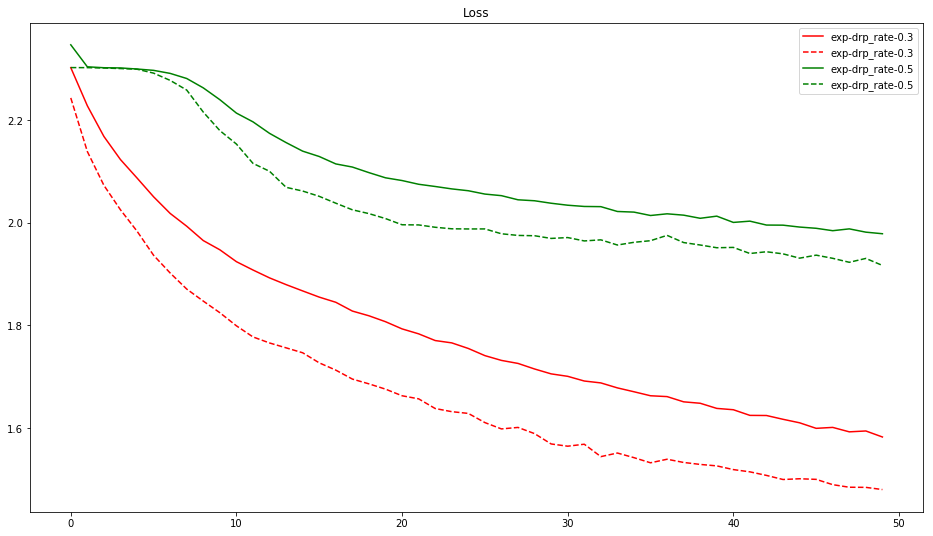

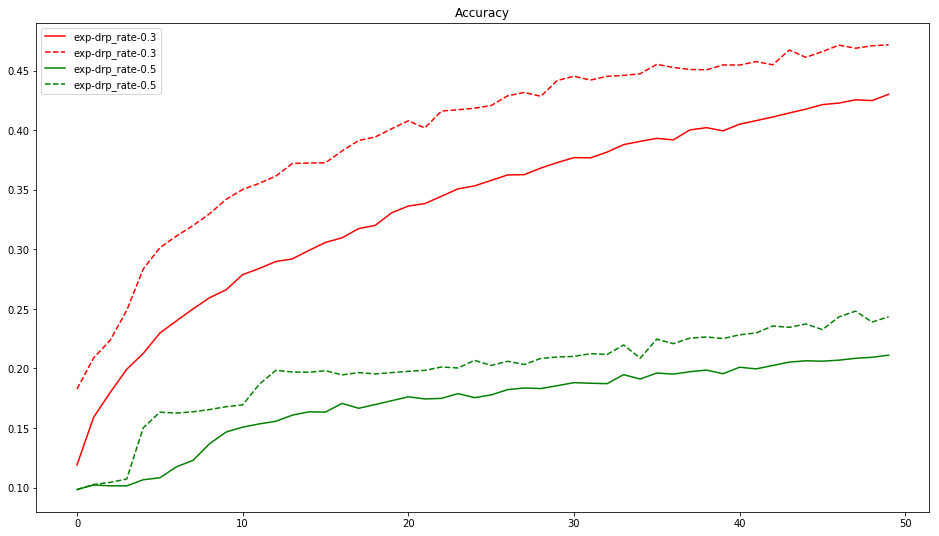

In [11]:
plt_model_result(results)

### 將 optimizer 改成使用 Adam

In [13]:
results = {}
for dropout_ratio in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout Ratio = %.6f" % (dropout_ratio))
    model = build_mlp(input_shape = x_train.shape[1:], num_neurons=[512, 256, 128, 64, 32], drp_ratio = dropout_ratio)
    model.summary()
    optimizer = optimizers.Adam(lr = LEARNING_RATE)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-drp_rate-%s" % str(dropout_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Dropout Ratio = 0.300000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None,

50000/50000 [==============================] - 20s 400us/step - loss: 1.7628 - acc: 0.3559 - val_loss: 1.7263 - val_acc: 0.3779
Epoch 46/50
50000/50000 [==============================] - 20s 403us/step - loss: 1.7622 - acc: 0.3575 - val_loss: 1.7069 - val_acc: 0.3819
Epoch 47/50
50000/50000 [==============================] - 20s 404us/step - loss: 1.7577 - acc: 0.3585 - val_loss: 1.6965 - val_acc: 0.3829
Epoch 48/50
50000/50000 [==============================] - 20s 404us/step - loss: 1.7575 - acc: 0.3577 - val_loss: 1.6997 - val_acc: 0.3840
Epoch 49/50
50000/50000 [==============================] - 20s 404us/step - loss: 1.7523 - acc: 0.3608 - val_loss: 1.6902 - val_acc: 0.3838
Epoch 50/50
50000/50000 [==============================] - 20s 403us/step - loss: 1.7511 - acc: 0.3648 - val_loss: 1.7267 - val_acc: 0.3812
Experiment with Dropout Ratio = 0.500000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

50000/50000 [==============================] - 20s 393us/step - loss: 2.1270 - acc: 0.1699 - val_loss: 2.2184 - val_acc: 0.1358
Epoch 40/50
50000/50000 [==============================] - 20s 408us/step - loss: 2.1276 - acc: 0.1689 - val_loss: 2.2161 - val_acc: 0.1373
Epoch 41/50
50000/50000 [==============================] - 21s 419us/step - loss: 2.1257 - acc: 0.1665 - val_loss: 2.2353 - val_acc: 0.1315
Epoch 42/50
50000/50000 [==============================] - 20s 397us/step - loss: 2.1286 - acc: 0.1666 - val_loss: 2.2129 - val_acc: 0.1449
Epoch 43/50
50000/50000 [==============================] - 20s 395us/step - loss: 2.1328 - acc: 0.1675 - val_loss: 2.2123 - val_acc: 0.1364
Epoch 44/50
50000/50000 [==============================] - 20s 396us/step - loss: 2.1239 - acc: 0.1689 - val_loss: 2.1970 - val_acc: 0.1423
Epoch 45/50
50000/50000 [==============================] - 20s 401us/step - loss: 2.1277 - acc: 0.1670 - val_loss: 2.2100 - val_acc: 0.1405
Epoch 46/50
50000/50000 [=======

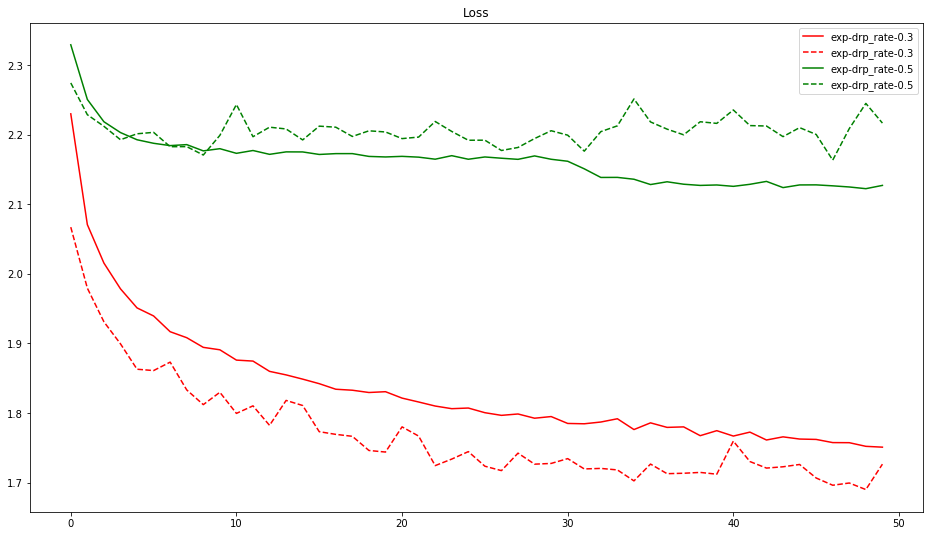

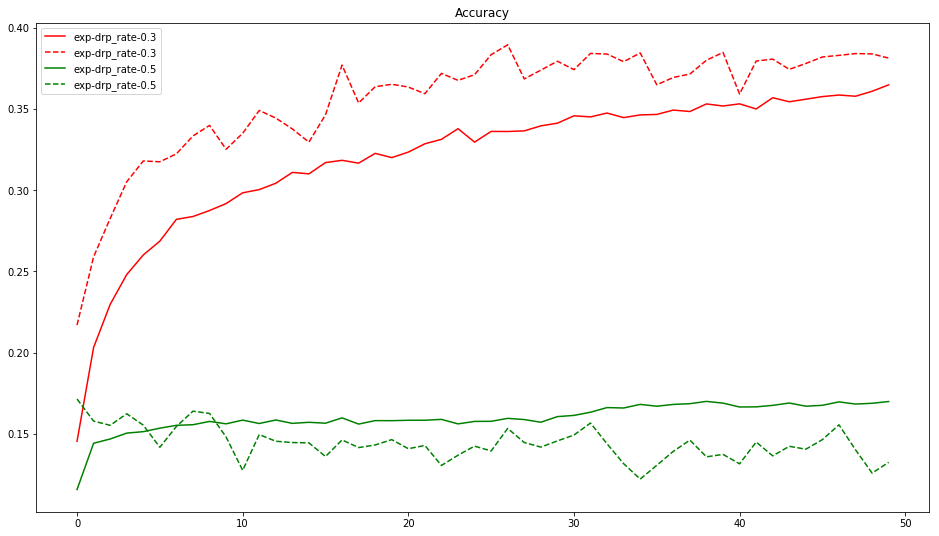

In [14]:
plt_model_result(results)